In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path

import programa_azoteas.indices as pindex
import programa_azoteas.data as pdata
import programa_azoteas.scenes as pscenes
import programa_azoteas.shapes as pshapes

In [3]:
# Direcciones a usar
root_infvit = Path("C:/Users/Mariana/Documents/unam/Proyecto_azoteas_verdes_satelite/Imagenes satelitales planet/Escenas/Infonavit")
root_prepa = Path("C:/Users/Mariana/Documents/unam/Proyecto_azoteas_verdes_satelite/Imagenes satelitales planet/Escenas/ENP8")
root_central = Path("C:/Users/Mariana/Documents/unam/Proyecto_azoteas_verdes_satelite/Imagenes satelitales extra/central_abastos_escenas")

# Infonavit

## Carga y limpieza de datos

In [4]:
# Shapes a usar del infonavit
shp_barranca = pshapes.get_shape("../Shapes area de estudio/Infonavit/calle_barranca.shp") # shp de área de infnvt hasta la calle que la rodea
shp_infnvt_azotea = pshapes.get_shape("../Shapes area de estudio/Infonavit/infnvt_azotea.shp") # Únicamnte de la azotea del infonavit
shp_infnvt_hole = pshapes.get_shape("../Shapes area de estudio/Infonavit/infnvt_hollow.shp") # shp de azotea pero con el hueco donde está el rectángulo

In [5]:
infnvt_full = pscenes.load_datasets(root_infvit) # Cargando todas las escenas del infonavit

In [6]:
infnvt_scenes = infnvt_full.rio.clip([shp_barranca]) # Clipping a la shape de la calle
infnvt_scenes = infnvt_scenes.fillna(0)
infnvt_scenes = pscenes.remove_nodata(infnvt_scenes) # Quitando aquellas donde no haya imagen

In [7]:
bands = ["cloud_shadow", "light_haze", "heavy_haze", "cloud"]
thresholds_infnvt = [0.01, 0.01, 0.01, 0.01] # Valores aceptables para c/u de las bandas

infnvt_area = pshapes.get_shape_area(infnvt_scenes, shp_infnvt_azotea)

infnvt_clean = infnvt_scenes.copy()
for band_name, threshold in zip(bands, thresholds_infnvt): # Quitando scenes que no cumplan con valores de threshold
    infnvt_clean = pscenes.clean_scenes(infnvt_clean, infnvt_area, band_name=band_name, threshold=threshold)

In [8]:
inf_sc_hole = infnvt_clean.rio.clip([shp_infnvt_hole]) # Clipping las escenas limpias a la shp del infonavit hueco

## Índices de vegetación

In [9]:
# Sacando promedio por mes de las escenas (área de estudio infonavit hueco)
inf_hole_monthly = inf_sc_hole.resample(time="M").mean()

c:\Users\Mariana\Documents\unam\Proyecto_azoteas_verdes_satelite\Programa_azoteas\.venv\Lib\site-packages\xarray\groupers.py:392: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


In [10]:
# Sacando valores de índices de vegetación (ndvi, evi y savi) de los promedios mensuales 
hole_monthly_ndvi = pindex.ndvi_scenes(inf_hole_monthly)
hole_monthly_evi = pindex.evi_scenes(inf_hole_monthly, shp_infnvt_hole)
hole_monthly_savi = pindex.savi_scenes(inf_hole_monthly, shp_infnvt_hole)

In [11]:
# Lista de cuts sobre los que se evalúa el VI (en este caso sólo uno, la misma shp del infonavit hueco)
cut_hole_lst ={
    "hollow" : shp_infnvt_hole
}

In [12]:
# Dataframe con los valores de VI mensuales
df_hole_indices = []
for key, value in cut_hole_lst.items():
    for df, name in zip([hole_monthly_ndvi, hole_monthly_evi, hole_monthly_savi], ["ndvi", "evi", "savi"]):
        temp_df = pdata.get_df_monthly(df, value)
        temp_df["name"] = name
        temp_df["cut"] = key
        df_hole_indices.append(temp_df)

df_hole_indices = (
    pd.concat(df_hole_indices)
    .reset_index()
    .rename(columns={"index": "date"})
    .set_index(["cut", "name", "date"])
    .sort_index()
)

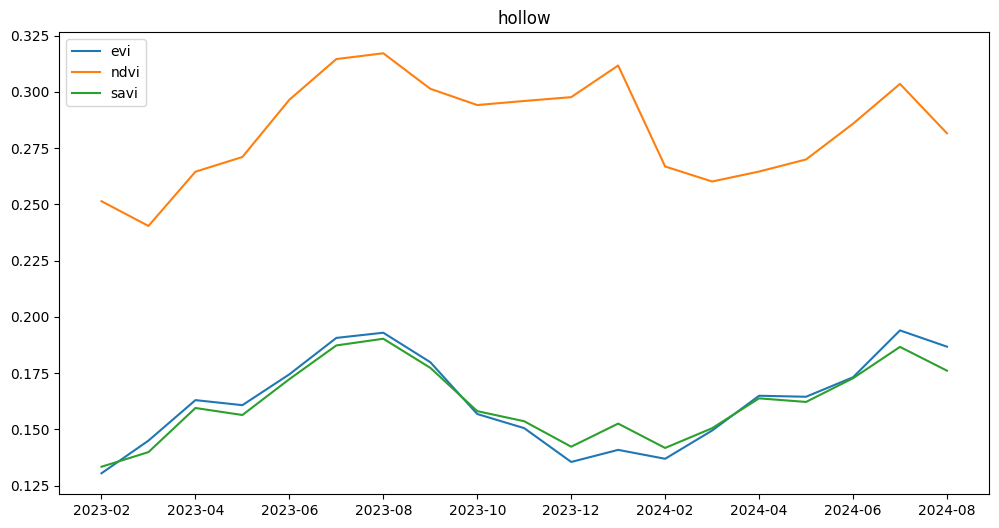

In [13]:
# fig, ax = plt.subplots(figsize=(12, 6))
# pindex.plot_index_comparison(df_hole_indices, "hollow", ax=ax)